In [ ]:
#!pip install sklearn

In [ ]:
#To visualize CSV data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import ast
#To copy and move images
import shutil
import os
# To split dataset
from sklearn.model_selection import StratifiedKFold
from matplotlib.pyplot import figure
import warnings

warnings.filterwarnings('ignore')

%matplotlib inline

In [ ]:
PATH = 'D:/Pictures/dataset/new_images/cells.csv'
IMG_ROOT = 'D:/Pictures/dataset/new_images/'

**CHECK CLASS IMBALANCE IN TARGET**

In [ ]:
data = pd.read_csv(PATH, delimiter=',', index_col=0)
data.head()

,img_name,class,bbox
0,BloodImage_00322.jpg,Platelets,"['168', '374', '198', '406']"
1,BloodImage_00322.jpg,Platelets,"['527', '244', '564', '282']"
2,BloodImage_00322.jpg,Platelets,"['565', '383', '602', '421']"
3,BloodImage_00322.jpg,WBC,"['307', '174', '528', '387']"
4,BloodImage_00377.jpg,RBC,"['448', '244', '566', '350']"


In [ ]:
data['class'].value_counts()

RBC          3739
WBC           372
Platelets     361
FBC             1
Name: class, dtype: int64

In [ ]:
data['class'].value_counts(normalize=True)

RBC          0.835904
WBC          0.083166
Platelets    0.080706
FBC          0.000224
Name: class, dtype: float64

The WBC and Platelets labels are associated to the 16% of the dataset only.
The data must be split using the labels for the stratification.
We then need to do data augmentation. In this way we are certain that none of the "augmented data" gets selected both in the train and in the test dataset.

**SINGLE INSTANCE: FBC**

The dataset contains one single instance of FBC. We need to exclude it from the database or apply data augmentation to it, with the risk of overfitting

In [ ]:
# Get image as numpy array
def load_image(name, path):
    img_path = path + name
    img = cv2.imread(img_path)
    return img

# Plot numpy array
def plot_image(img):
    plt.imshow(img)
    plt.title(img.shape)
    
# Plot a grid of examples
def plot_grid(img_names, img_root, rows=5, cols=5):
    fig = plt.figure(figsize=(25,25))
    
    for i,name in enumerate(img_names):
        fig.add_subplot(rows,cols,i+1)
        img = load_image(name, img_root)
        plot_image(img)
        
    plt.show()

def class_to_color(class_id):
    colors = {'Platelets':(255,0,0),'WBC':(0,255,0),'RBC':(0,0,255), 'FBC':(255,255,0)}
    return colors[class_id]

# draw a single bounding box onto a numpy array image
def draw_bounding_box(img, annotation):
    if annotation.isnull().values.any():
        return
    coord=ast.literal_eval(annotation['bbox'])
    x_min, y_min = int(coord[0]), int(coord[1])
    x_max, y_max = int(coord[2]), int(coord[3])
    
    class_id = annotation['class']
    color = class_to_color(class_id)
    
    cv2.rectangle(img,(x_min,y_min),(x_max,y_max), color, 2)

# draw all annotation bounding boxes on an image
def annotate_image(img, name, all_annotations):
    annotations = all_annotations[all_annotations['img_name'] == name]
    for index, row in annotations.iterrows():
        draw_bounding_box(img, row)


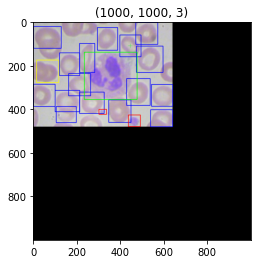

In [ ]:

# Plot a single sample with all its bounding boxes
name = 'BloodImage_00396.jpg'
img = load_image(name, IMG_ROOT)
annotate_image(img, name, data)
plot_image(img)

**SPLIT THE DATASET**

The dataset will be split in 2 parts because of his limited size.

Furthermore, it will be split 80/20 because of his limited size.

In [ ]:
onlyfbc=data[data['class']=="FBC"]
imgpath=IMG_ROOT+str(onlyfbc['img_name'].to_string(index=False))
print(imgpath)

D:/Pictures/dataset/new_images/BloodImage_00396.jpg


Copy to Train folder

In [ ]:

dst_dir = IMG_ROOT+'train/'+str(onlyfbc['img_name'].to_string(index=False))
shutil.copyfile(str(imgpath), str(dst_dir))

'D:/Pictures/dataset/new_images/train/BloodImage_00396.jpg'

Copy the image also to Test

In [ ]:
dst_dir = IMG_ROOT+'test/'+str(onlyfbc['img_name'].to_string(index=False))
shutil.copyfile(str(imgpath), str(dst_dir))

'D:/Pictures/dataset/new_images/test/BloodImage_00396.jpg'

To split the dataset, a Stratified KFold is used. We select one of the 5 folds (containing 20% of the data) and we keep the rest for the training

                      bbox_count  object_count stratify_group
img_name                                                     
BloodImage_00000.jpg          20             2            2_1
BloodImage_00001.jpg          19             2            2_1
BloodImage_00002.jpg          16             2            2_1
BloodImage_00003.jpg          17             3            3_1
BloodImage_00004.jpg          13             3            3_0
...                          ...           ...            ...
BloodImage_00405.jpg          15             2            2_1
BloodImage_00407.jpg          19             3            3_1
BloodImage_00408.jpg          18             3            3_1
BloodImage_00409.jpg          19             3            3_1
BloodImage_00410.jpg          18             3            3_1

[364 rows x 3 columns]


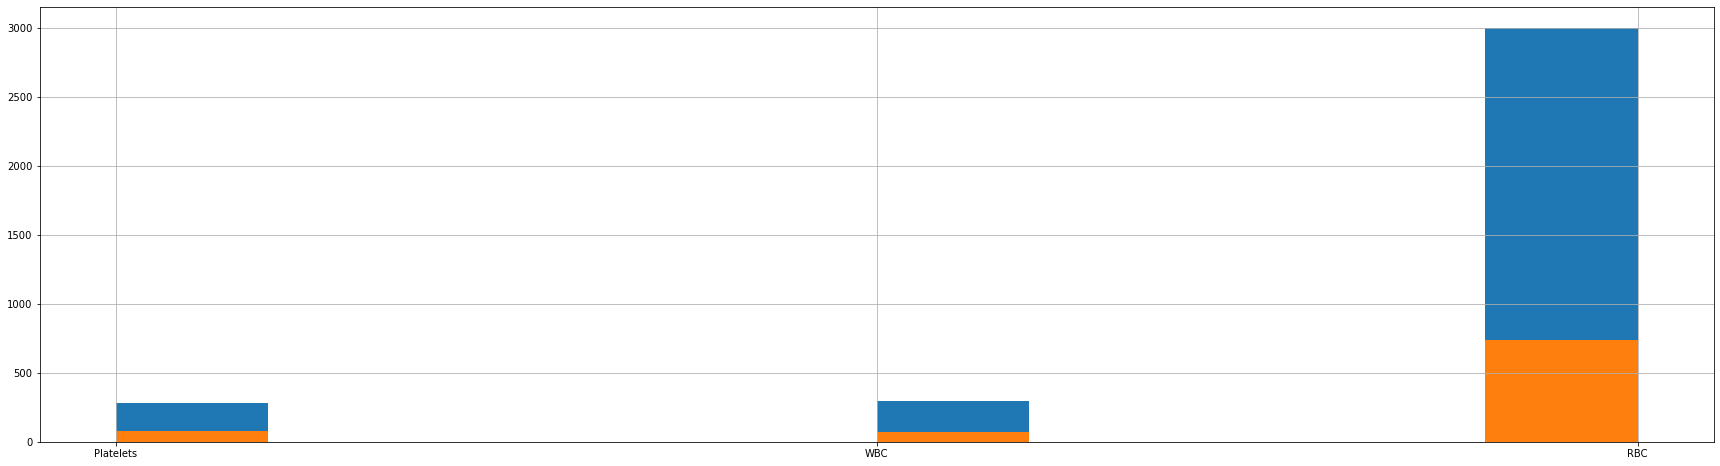

In [ ]:

df = pd.read_csv(r'D:/Pictures/dataset/new_images/cells.csv')
df = pd.DataFrame(df)
df = df[df['class'] != 'FBC']

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=101)
df_folds = df[['img_name']].copy()

#I get a table with each picture name and the count of the bounding boxes
df_folds.loc[:, 'bbox_count'] = 1
df_folds = df_folds.groupby('img_name').count()

#I associate the number of unique labels for picture
df_folds.loc[:, 'object_count'] = df.groupby('img_name')['class'].nunique()

df_folds.loc[:, 'stratify_group'] = np.char.add(
    df_folds['object_count'].values.astype(str),
    df_folds['bbox_count'].apply(lambda x: f'_{x // 15}').values.astype(str)
)

print(df_folds)

df_folds.loc[:, 'fold'] = 0
for fold_number, (train_index, val_index) in enumerate(skf.split(X=df_folds.index, y=df_folds['stratify_group'])):
    df_folds.loc[df_folds.iloc[val_index].index, 'fold'] = fold_number

# example with fold 0
df_folds.reset_index(inplace=True)

df_valid = pd.merge(df, df_folds[df_folds['fold'] == 0], on='img_name')

df_train = pd.merge(df, df_folds[df_folds['fold'] != 0], on='img_name')

figure(num=None, figsize=(30, 8))
df_train['class'].hist()
df_valid['class'].hist()
plt.show()

In [ ]:
df_train.to_csv(str(IMG_ROOT+str("/train.csv")))
df_valid.to_csv(str(IMG_ROOT+str("/valid.csv")))

Move all the images in test and train folder

In [ ]:
for element in list(df_train['img_name'].unique()):
  imgpath=IMG_ROOT+str(element)
  dst_dir = IMG_ROOT+'train/'+str(element)
  os.replace(imgpath, dst_dir)

In [ ]:
for element in list(df_valid['img_name'].unique()):
  imgpath=IMG_ROOT+str(element)
  dst_dir = IMG_ROOT+'test/'+str(element)
  os.replace(imgpath, dst_dir)